In [4]:
import numpy as np
import pandas as pd
from scipy.stats import wishart
from scipy.special import digamma, softmax
from scipy.stats.distributions import chi2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from tqdm import tqdm

%config InlineBackend.figure_formats = ['svg']

In [5]:
# Initialize approximate posteriors q(π), q(μ_k,Λ_k) directly from the priors.
# q(pi) to be dirichlet with a0=10e-3; q(μ_k,Λ_k)
# for normalized data, maybe we can start off with wishart of mean I = Wv; if v=2, then w=I/2
# m0 is set to 0, and we choose beta to be 1

In [6]:
x = pd.read_csv("faithful.csv")
x

,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85
...,...,...,...
267,268,4.117,81
268,269,2.150,46
269,270,4.417,90
270,271,1.817,46


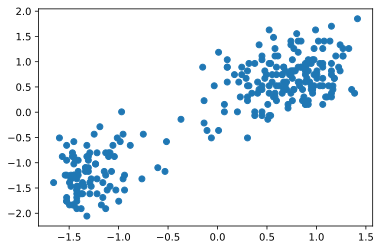

In [7]:
x = pd.read_csv("faithful.csv").to_numpy()[:, 1:]
x = (x - x.mean(axis=0).reshape(1, -1)) / x.std(axis=0).reshape(1, -1)

plt.scatter(x[:, 0], x[:, 1])
plt.show()

In [8]:
C = 10
D = 2
N = 100
T = 200

In [9]:
# prior parameters
α_0 = 1e-3

# below are shared across clusters
υ_0 = 2
W_0 = np.eye(2) / υ_0
np.random.seed(30)
m_0 = np.random.normal(loc=0, scale=1, size=(C, D))
β_0 = 1

In [10]:
m_0

array([[-1.26405266,  1.52790535],
       [-0.97071094,  0.47055962],
       [-0.10069672,  0.30379318],
       [-1.72596243,  1.58509537],
       [ 0.13429659, -1.10685547],
       [ 1.57822555,  0.10749794],
       [-0.76404783, -0.77518851],
       [ 1.38384717,  0.76038508],
       [-0.28564551,  0.53836748],
       [-2.08389663,  0.93778171]])

In [11]:
# should be close to I if v_0 is large, e.g., 1000
wishart(scale=W_0, df=υ_0).rvs()

array([[ 1.80008459, -0.00548162],
       [-0.00548162,  0.13469639]])

In [12]:
def to_vec(array_1d):
    return array_1d.reshape(-1, 1)

In [13]:
np.zeros(6)

array([0., 0., 0., 0., 0., 0.])

In [14]:
from copy import deepcopy

In [15]:
# ========== posterior parameter storage ==========

# parameters of q(π) at timestep t
α_t = np.zeros((C, ))

# parameters of q(μ_k|Λ_k) at timestep t
m_t = np.zeros((C, D))  
β_t = np.zeros((C, ))

# parameters of q(Λ_k) at timestep t
W_t = np.zeros((C, D, D))
υ_t = np.zeros((C, ))

# # parameters of q(Z) at timestep t
# r_t = np.zeros((N, D))

# ========== initialize posterior parameter to kickstart to algorithm ===========

α_t[:] = α_0
# m_t[:] = m_0
m_t = deepcopy(m_0)
β_t[:] = β_0
W_t[:] = deepcopy(W_0)
υ_t[:] = υ_0

# ============ run the algorithm for T iterations ============

for t in tqdm(range(T)):
    
    # compute statistics required to compute q(Z)
    
    term_10_64_t = np.zeros((N, C))
    for i in range(N):
        for k in range(C):
            term_10_64_t[i, k] = D * 1/(β_t[k]) + υ_t[k] * to_vec(x[i] - m_t[k]).T @ W_t[k] @ to_vec(x[i] - m_t[k])
    
    term_10_65_t = np.zeros((C, ))
    for k in range(C):
        term_10_65_t[k] = D * np.log(2) + np.log(np.linalg.det(W_t[k]))
        for d in range(D):
            term_10_65_t[k] += digamma((υ_t[k] + 1 - d) / 2)
    
    term_10_66_t = np.zeros((C, ))
    for k in range(C):
        term_10_66_t[k] = digamma(α_t[k]) - digamma(α_t.sum())
    
    # compute (parameters of) q(Z)
    
    log_ρ_t = term_10_66_t.reshape(1, C) + 0.5 * term_10_65_t.reshape(1, C) - (D/2) * np.log(2 * np.pi) - 0.5 * term_10_64_t
    # ρ_t = np.exp(log_ρ_t)
    # r_t = ρ_t / ρ_t.sum(axis=1).reshape((N, 1))
    r_t = softmax(log_ρ_t, axis=1)  # use softmax instead to deal with numerical problems
    
#     if t == 1:
#         break
    
    # compute statistics required to compute q(π), q(μ_k|Λ_k), q(Λ_k)
    
    # (done! we just need r_t)
    
    # compute (parameters of) q(π), q(μ_k|Λ_k), q(Λ_k)
    
    N_t = r_t.sum(axis=0)  # 10.51
    
    xbar_t = np.zeros((C, D))  # 10.52
    for k in range(C):
        if np.allclose(N_t[k], 0):
            xbar_t[k] = np.zeros((2, ))
        else:
            xbar_t[k] = (1 / N_t[k]) * np.sum([r_t[i, k] * x[i] for i in range(N)], axis=0)
    
    S_t = np.zeros((C, D, D))  # 10.53
    for k in range(C):
        if np.allclose(N_t[k], 0):
            S_t[k] = np.zeros((2, 2))
        else:
            S_t[k] = (1 / N_t[k]) * np.sum([r_t[i, k] * to_vec(x[i] - xbar_t[k]) @ to_vec(x[i] - xbar_t[k]).T for i in range(N)], axis=0)
    
    for k in range(C):
        α_t[k] = α_0 + N_t[k]  # 10.58
        β_t[k] = β_0 + N_t[k]
        m_t[k] = (1 / β_t[k]) * (β_0 * m_0[k] + N_t[k] * xbar_t[k])
        W_t[k] = np.linalg.inv(
            np.linalg.inv(W_0) + 
            N_t[k] * S_t[k] + 
            (β_0 * N_t[k]) / (β_0 + N_t[k]) * to_vec(xbar_t[k] - m_0[k]) @ to_vec(xbar_t[k] - m_0[k]).T
        )
        υ_t[k] = υ_0 + N_t[k]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.97it/s]


## Sanity check

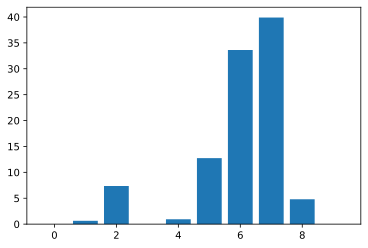

In [16]:
plt.bar(np.arange(len(α_t)), α_t)
plt.show()

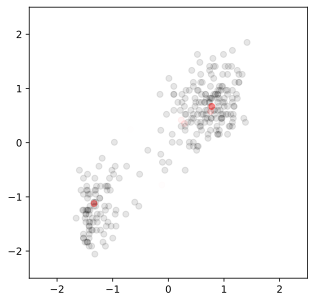

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1], color="black", alpha=0.1)
for k in range(C):
    plt.scatter(m_t[k][0], m_t[k][1], color="red", alpha=α_t[k] / np.sum(α_t))
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

## Contours

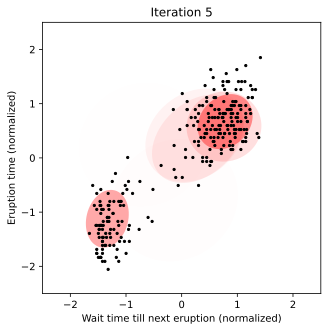

In [18]:
# https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

plt.figure(figsize=(5, 5))

for k in range(C):
    
    mean_cov_matrix = np.linalg.inv(W_t[k]) / υ_t[k]
    eigval, eigvec = np.linalg.eig(mean_cov_matrix)
    
    indices = np.argsort(eigval)
    if not indices[0] == 0:
        eigval = np.array([eigval[1], eigval[0]])
        eigvec = np.array([eigvec[:,1], eigvec[:,0]]).T
    
    ellipse = Ellipse(
        xy=(m_t[k][0], m_t[k][1]), 
        height=2*np.sqrt(chi2.ppf(0.50, df=2)*eigval[0]), 
        width=2*np.sqrt(chi2.ppf(0.50, df=2)*eigval[1]), 
        angle=np.arctan(eigvec[:,1][1] / (eigvec[:,1][0] + 1e-5)) / np.pi * 180,
        fc='red', 
        alpha=α_t[k] / np.sum(α_t))
    plt.gca().add_patch(ellipse)

plt.scatter(x[:, 0], x[:, 1], color="black", alpha=1, s=5)
    
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.xlabel("Wait time till next eruption (normalized)")
plt.ylabel("Eruption time (normalized)")
plt.title(f"Iteration {T}")

plt.savefig(f"bayesian_mixture_of_gaussians/iter_{T}.png", dpi=100, bbox_inches='tight')

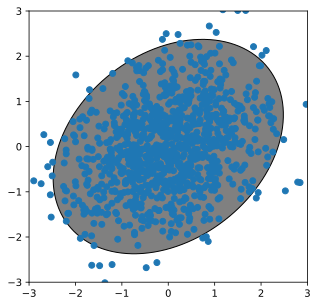

In [20]:
# # a sanity check of chi2.ppf

# X = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.3], [0.3, 1]], size=1000)
# X = X - np.mean(X, axis=0).reshape(1, -1)
# cov = X.T @ X / len(X)
# eigval, eigvec = np.linalg.eig(cov)

# plt.figure(figsize=(5, 5))

# ellipse = Ellipse(
#         xy=(0, 0), 
#         height=2*np.sqrt(chi2.ppf(0.95, df=2)*eigval[0]), 
#         width=2*np.sqrt(chi2.ppf(0.95, df=2)*eigval[1]), 
#         angle=np.arctan(eigvec[:,1][1] / (eigvec[:,1][0] + 1e-3)) / np.pi * 180,
#         edgecolor='black',
#         fc='gray', 
# )

# plt.gca().add_patch(ellipse)

# plt.scatter(X[:,0], X[:,1], alpha=1)

# plt.xlim(-3, 3)
# plt.ylim(-3, 3)

# plt.show()